In [72]:
# pre-processing tables

# Opsin receptor proteins were chosen from HGNC database in the group labled Opsin receptors.
# Immune ligands were compiled from the Gene Ontology database using the following search terms:
# chemokines, cytokines, toll, tumor necrosis factor, bone morphogenic proteins, interferons, interleukins,
# tachykinin, and endothelins. These were chosen as the HGNC database indicated that they all have a large 
# involvement in the immune system. This was also checked when pulling the data as the filters that were applied
# were that the genes needed to be Homo sapien genes, they needed to be involved in regulation of the immune
# system, and they needed to be UniProt ID genes (so as to avoid including duplicates from differnet ID systems).

import pandas as pd

opsins = pd.read_csv("Opsins2.csv") 
immune = pd.read_csv("Immune_Proteins_Readout3.csv") 


opsins_proc = opsins[["HGNC ID (gene)", "Approved symbol"]]
immune_proc = immune[["ID", "Gene"]]

opsins_list = []
immune_list = []

for element in opsins_proc['Approved symbol']:
    opsins_list.append(element)

for element in immune_proc['Gene']:
    immune_list.append(element)

opsins_list = list(set(opsins_list))
immune_list = list(set(immune_list)) # I converted the list to a set and then back to a list to make sure that I only had unique elements in the list as when compiling, I noticed that some ligands would be repeated in different search terms.

display(opsins_proc)
display(immune_proc) 

,HGNC ID (gene),Approved symbol
0,HGNC:9936,OPN1LW
1,HGNC:4206,OPN1MW
2,HGNC:26952,OPN1MW2
3,HGNC:51831,OPN1MW3
4,HGNC:1012,OPN1SW
5,HGNC:10012,RHO
6,HGNC:14007,OPN3
7,HGNC:14449,OPN4
8,HGNC:19992,OPN5
9,HGNC:9990,RGR


,ID,Gene
0,UniProtKB:P22003,BMP5
1,UniProtKB:P12644,BMP4
2,UniProtKB:P02818,BGLAP
3,UniProtKB:O00300,TNFRSF11B
4,UniProtKB:P13686,ACP5
...,...,...
1818,UniProtKB:Q14289,PTK2B
1819,UniProtKB:P05305,EDN1
1820,UniProtKB:Q96EB6,SIRT1
1821,UniProtKB:P23771,GATA3


In [74]:
combined_list = opsins_list + immune_list
print(len(immune_list)) #there are 1466 duplicates in the original immune ligand csv file
print(len(combined_list))

773
784


In [88]:
#Observed Number of Interactions

interactions = pd.read_csv("NIHMS251242-supplement-s6.csv")
io_observed_interactions = 0

for index, row in interactions.iterrows(): # This for loop checks to see if the gene in column 1 and the gene in column 2 have elements in the list of input opsin and immune genes
    if (row['GENE1'] in opsins_list) and (row['GENE2'] in immune_list):
        io_observed_interactions+=1
    elif (row['GENE1'] in immune_list) and (row['GENE2'] in opsins_list):
        io_observed_interactions+=1

print("Immune and Opsin Observed Interactions", io_observed_interactions)

iother_observed_interactions = 0

for index, row in interactions.iterrows(): # This loop checks for interactions that only have an immune ligand from the input immune list
    if (row['GENE1'] not in opsins_list) and (row['GENE2'] in immune_list):
        iother_observed_interactions+=1
    elif (row['GENE1'] in immune_list) and (row['GENE2'] not in opsins_list):
        iother_observed_interactions+=1
        
print("Immune and Other Expected Interactions", iother_observed_interactions)

oother_observed_interactions = 0

for index, row in interactions.iterrows(): # This loop checks for interactions that only have an opsin receptor from the input opsins list
    if (row['GENE1'] in opsins_list) and (row['GENE2'] not in immune_list):
        oother_observed_interactions+=1
    elif (row['GENE1'] not in immune_list) and (row['GENE2'] in opsins_list):
        oother_observed_interactions+=1
        
print("Opsin and Other Expected Interactions", oother_observed_interactions)
        
print("Other and Other Expected Interactions", 42703 - io_observed_interactions - iother_observed_interactions - oother_observed_interactions)

Immune and Opsin Observed Interactions 10
Immune and Other Expected Interactions 13471
Opsin and Other Expected Interactions 64
Other and Other Expected Interactions 29158


In [ ]:
#Observed Numbers

#         opsin       others

# immune   10          13471

# others   64         29158

In [78]:
#Expected Number of Interactions
#Formula is Expected number of interactions = (number of opsins/total number of proteins) x (number of immune system molecules/total number of proteins) x total number of possible interactions
#Number of opsins is the length of opsins_proc, number of immune system molecules is immune_proc, total number of protein-coding genes was found from the GO term databse, and total number of possible interactions is the length of the interactions database
opsin_num = len(opsins_list)
immune_num = len(immune_list)
total_proteins = 19632

io_expected_interactions = (opsin_num/total_proteins) * (immune_num/total_proteins) * len(interactions)
print("Immune and Opsin Expected Interactions", io_expected_interactions)
iother_expected_interactions = ((total_proteins-opsin_num)/total_proteins) * (immune_num/total_proteins) * len(interactions)
print("Immune and Other Expected Interactions", iother_expected_interactions)
oother_expected_interactions = ((total_proteins-immune_num)/total_proteins) * (opsin_num/total_proteins) * len(interactions)
print("Opsin and Other Expected Interactions", oother_expected_interactions)
other_other_expected_interactions = ((total_proteins-immune_num)/total_proteins) * ((total_proteins-opsin_num)/total_proteins) * len(interactions)
print("Other and Other Expected Interactions", other_other_expected_interactions)


Immune and Opsin Expected Interactions 0.9421096987545572
Immune and Other Expected Interactions 1680.466763569379
Opsin and Other Expected Interactions 22.98479535422018
Other and Other Expected Interactions 40998.60633137765


In [ ]:
#Expected Numbers

#         opsin       others

# immune  0.94        1680.47

# others  22.98       40998.61

In [98]:
# Using Chi Squared Test to check the significance of the difference between the expected and observed interaction values

from scipy import stats

data = [['Immune and Opsin', 10, io_expected_interactions], ['Immune and Other', 13471, iother_expected_interactions], ['Opsin and Other', 64, oother_expected_interactions], ['Other and Other', 29158, other_other_expected_interactions]] 
chisquare_df = pd.DataFrame(data, columns = ['VarName', 'Observed', 'Expected']) 
alpha = 0.05 # we set our significance level to be 0.05

display(chisquare_df)

chi_square = 0
for i in range(len(chisquare_df)):
    O = chisquare_df.loc[i, 'Observed']
    E = chisquare_df.loc[i, 'Expected']
    chi_square += ((O-E)**2)/E

print(chi_square)

p_value = 1 - stats.chi2.cdf(chi_square, chisquare_df['VarName'].nunique() - 1)
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
    
print("chisquare-score is:", chi_square, "and p value is:", p_value)
print(conclusion)

# Since the p value is less than the significance level, then we reject the null hypothesis that the associations we see are due to random chance
# Thus, there's evidence of a nonrandom association and number of interactions between opsins and immune proteins.
# It indicates that there is an over-representation of associations between opsins and immune system molecules.
# Completing the same chi square but using the critical value method instead of the p-value method to confirm the previous analysis:

critical_value = stats.chi2.ppf(1-alpha, chisquare_df['VarName'].nunique() - 1)
print(critical_value)
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."

print(conclusion)

# Based on the two chi square methods yielding the same conclusions, we can see that the number of protein protein interactions between
# opsin receptors and immune ligands are overrepresented.

,VarName,Observed,Expected
0,Immune and Opsin,10,0.942110
1,Immune and Other,13471,1680.466764
2,Opsin and Other,64,22.984795
3,Other and Other,29158,40998.606331


86304.9401263157
chisquare-score is: 86304.9401263157 and p value is: 0.0
Null Hypothesis is rejected.
7.814727903251179
Null Hypothesis is rejected.


In [96]:
#Creating a csv file with a dataframe containing all the immune ligand and opsin receptor interactions

interactions_data = []

for index, row in interactions.iterrows():
    if (row['GENE1'] in opsins_list) and (row['GENE2'] in immune_list):
        interactions_data.append([row['GENE2'], row['GENE1']])
    elif (row['GENE2'] in opsins_list) and (row['GENE1'] in immune_list):
        interactions_data.append([row['GENE1'], row['GENE2']])

interactions_df = pd.DataFrame(interactions_data, columns = ["Immune Ligand", "Opsin Receptor"])

interactions_df.to_csv("Opsin_Immune_Interactions.csv")
display(interactions_df)

,Immune Ligand,Opsin Receptor
0,TBX21,OPN4
1,PTPN11,OPN3
2,CD80,RHO
3,PTPN1,OPN3
4,PTPRS,OPN3
5,PTPN6,OPN3
6,PTPN22,RGR
7,PTPRC,OPN3
8,TACR1,RRH
9,PTPRS,RGR


In [82]:
#Creating a Dictionary of the Interactions to make a network graph in the next cell
interactions_dic = {}

for pair in interactions_data:
    if pair[1] not in interactions_dic.keys():
        interactions_dic[pair[1]] = [pair[0]]
    else:
        interactions_dic[pair[1]].append(pair[0])

print(interactions_dic)

{'OPN4': ['TBX21'], 'OPN3': ['PTPN11', 'PTPN1', 'PTPRS', 'PTPN6', 'PTPRC'], 'RHO': ['CD80'], 'RGR': ['PTPN22', 'PTPRS'], 'RRH': ['TACR1']}


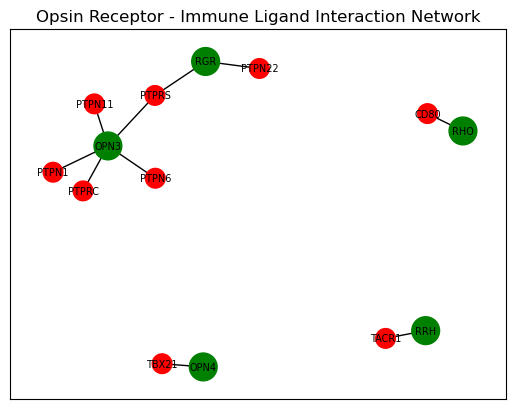

In [103]:
import networkx as nx
import matplotlib.pyplot as plt

# Creating a NetworkX graph
G = nx.Graph()

# Adding nodes for each opsin receptor
G.add_nodes_from(interactions_dic.keys(), color='green', size=400)

# Adding nodes for each immune ligand and connecting them to the corresponding opsin receptor
for opsin, ligands in interactions_dic.items():
    for ligand in ligands:
        G.add_node(ligand, color='red', size=200)
        G.add_edge(opsin, ligand)

# Setting node colors and sizes
node_colors = [node_data['color'] for _, node_data in G.nodes(data=True)]
node_sizes = [node_data['size'] for _, node_data in G.nodes(data=True)]

# Creating the graph layout
pos = nx.spring_layout(G, k = 0.5)

# Drawing the graph nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos)

# Adding labels to the graph nodes
labels = {node: node.split()[1] if 'Opsin' in node else node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=7)

# Adding a title to the graph
plt.title('Opsin Receptor - Immune Ligand Interaction Network')

# Displaying the graph
plt.show()

# Examining this graph, we can see that there aren't very many interactions between the Opsin Receptor and Ligands,
# but based on the significance tests conducted beforehand, their interactions are signficant. We can see that
# OPN3 is a very well-interacted-with receptor, having connections with immune ligand genes such as PTPN1, PTPN11,
# PTPRC, PTPN6, and PTPRS. These genes are Protein Tyrosine Phosphatase genes and are often involved in immune
# system regulation by interacting with interleukins and other immune system related molecules. We can also see that
# CD80, a molecule that plays a role in T cell activation, interacts with RHO which is the gene responsible
# for making rhodopsin. Another interesting view in the network graph is that PTPRS binds to both OPN3 and RGR which
# shows that there is non-specific binding occuring between those molecules. This means that there is a potential
# for there to be even more non-specific binding and protein protein interactions if the list of predicted
# interactions used for this analysis was extended to include Scores below 1.